affect classification with baselines from https://github.com/phamquiluan/ResidualMaskingNetwork#benchmarking_fer2013


In [1]:
# grab data (https://stackoverflow.com/questions/65099766/is-there-a-way-to-download-data-from-a-public-link-to-google-colab)
!gdown --id 13JvaRtXkV_oZ8K-7iOH736OhQ2eAMENB
!gdown --id 1f8wUtQj-UatrZtCnkJFcB--X2eJS1m_N

Downloading...
From: https://drive.google.com/uc?id=13JvaRtXkV_oZ8K-7iOH736OhQ2eAMENB
To: /content/test.csv
30.1MB [00:00, 184MB/s]
Downloading...
From: https://drive.google.com/uc?id=1f8wUtQj-UatrZtCnkJFcB--X2eJS1m_N
To: /content/densenet121_rot30_2019Nov11_14.23
28.3MB [00:00, 173MB/s]


In [2]:
# setup data

EMOTION_DICT = {
    0: "angry",
    1: "disgust",
    2: "fear",
    3: "happy",
    4: "sad",
    5: "surprise",
    6: "neutral",
}

import os
import cv2
import numpy as np
import pandas as pd
from torchvision.transforms import transforms
from torch.utils.data import Dataset

class Fer2013(Dataset):
    def __init__(self, stage, configs):
        self._stage = stage
        self._configs = configs

        self._image_size = (configs["image_size"], configs["image_size"])

        self._data = pd.read_csv(
            os.path.join(configs["data_path"], "{}.csv".format(stage))
        )

        self._pixels = self._data["pixels"].tolist()
        self._emotions = pd.get_dummies(self._data["emotion"])

        self._transform = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ]
        )

    def __len__(self):
        return len(self._pixels)

    def __getitem__(self, idx):
        pixels = self._pixels[idx]
        pixels = list(map(int, pixels.split(" ")))
        image = np.asarray(pixels).reshape(48, 48)
        image = image.astype(np.uint8)

        image = cv2.resize(image, self._image_size)
        image = np.dstack([image] * 3)

        image = self._transform(image)
        target = self._emotions.iloc[idx].idxmax()
        return image, target

# load test data

conf = {
	"data_path": "./",
	"image_size": 224
}
test_set = Fer2013("test", conf)

In [3]:
# load model

import torch
import torch.nn as nn
from torchvision import models

model_ft = models.densenet121()
num_ftrs = model_ft.classifier.in_features
model_ft.classifier = nn.Linear(num_ftrs, len(EMOTION_DICT)) 
input_size = 224
model_ft.load_state_dict(torch.load("./densenet121_rot30_2019Nov11_14.23")['net'])

<All keys matched successfully>

label: happy


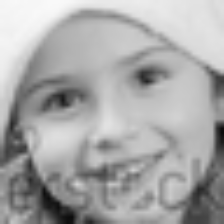

In [4]:
# choose an image and visualize it

EXAMPLE_NUM = 128 # 128 and 11 are good examples of happy

from PIL import Image
import numpy as np

data_point = test_set[EXAMPLE_NUM]
print("label:", EMOTION_DICT[data_point[1]])

# for visualization convert from float 0 to 1 into uint8 0 254 and move channel dim to end
img = np.moveaxis((data_point[0].numpy()* 254).astype('uint8'), 0, -1)
Image.fromarray(img, 'RGB')

In [5]:
# inference
import torch.nn.functional as F

model_ft.eval()
with torch.no_grad():
  logits = model_ft(data_point[0].unsqueeze(0))
  probs = F.softmax(logits.squeeze(), dim = 0)
  probs, preds = probs.topk(len(probs))

for i, (prob, pred) in enumerate(zip(probs, preds)):
  print("prediciton", i +1)
  print(EMOTION_DICT[pred.item()])
  print(prob.item())
  print()

prediciton 1
happy
0.9959180951118469

prediciton 2
neutral
0.00304922997020185

prediciton 3
surprise
0.000994177651591599

prediciton 4
fear
2.7530830266186967e-05

prediciton 5
angry
5.766171398136066e-06

prediciton 6
sad
3.6869162158836843e-06

prediciton 7
disgust
1.5012176390882814e-06

